## *Análisis del Dataset de insuficiencia cardiaca* heart_failure_clinical_records_dataset.csv de Kaggle

### **Presentado por:**

Angélica Órtiz Álvarez (aortiz016@soyudemedellin.edu.co)

Jhon Jader Diaz Gomez (jdiaz510@soyudemedellin.edu.co)

Cristian Camilo Ospina Metaute (cospina149@soyudemedellin.edu.co)

## Se importan las librerías requeridas para manipulación de datos y manejo de medelos

In [273]:
import numpy as np 
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path

## Se carga el dataset heart_failure_clinical_records_dataset.csv de [Kaggle](https://www.kaggle.com/code/arjunamla02/logistic-regession-vs-decision-tree-vs-rf/notebook) - [UCI Irvine](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)


In [274]:
# Se carga de dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()   

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Debido a que la base de datos original tiene solo 299 registros, se simula 2700 adicionales para completar 3000, de manera que tengamos una base de datos con suficientes datos y con ruido para hacer el ejercicio de manipulación de datos.

In [275]:
# Definición de las columnas y sus tipos de datos esperados
# Basado en la estructura del dataset "heart_failure_clinical_records_dataset"
columns = [
    'age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
    'ejection_fraction', 'high_blood_pressure', 'platelets',
    'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
    'DEATH_EVENT'
]

# Rango de valores (aproximados, basados en el dataset original) para la generación sintética
data_ranges = {
    'age': (40, 95),
    'anaemia': (0, 1), # Binario
    'creatinine_phosphokinase': (23, 7861), # Valor alto para simular la dispersión
    'diabetes': (0, 1), # Binario
    'ejection_fraction': (14, 80),
    'high_blood_pressure': (0, 1), # Binario
    'platelets': (100000, 850000), # Rango amplio
    'serum_creatinine': (0.5, 9.4),
    'serum_sodium': (113, 148),
    'sex': (0, 1), # Binario (Mujer=0, Hombre=1 o viceversa, solo necesitamos el binario)
    'smoking': (0, 1), # Binario
    'time': (4, 285),
    'DEATH_EVENT': (0, 1) # Binario (Target)
}

# --- 1. Simulación de los 299 Registros Originales (Base) ---
# Creamos un DataFrame base de 299 filas con datos limpios y aleatorios dentro del rango,
# para simular la parte original del dataset.

np.random.seed(42) # Para reproducibilidad

base_records = 299
data_base = {}

# Generar datos limpios para la base
for col in columns:
    min_val, max_val = data_ranges[col]

    if col in ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'time']:
        data_base[col] = np.random.randint(min_val, max_val + 1, base_records)
    elif col in ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']:
        data_base[col] = np.random.randint(min_val, max_val + 1, base_records)
    elif col in ['platelets']:
        # Simular números grandes, a veces con decimales como en el dataset original
        data_base[col] = np.round(np.random.uniform(min_val, max_val, base_records), 2)
    elif col in ['serum_creatinine', 'serum_sodium']:
        data_base[col] = np.round(np.random.uniform(min_val, max_val, base_records), 2)

df_base = pd.DataFrame(data_base)

# Asegurar que las columnas binarias y enteras sean de tipo entero en la base
int_cols = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
            'ejection_fraction', 'high_blood_pressure', 'sex', 'smoking',
            'time', 'DEATH_EVENT']
for col in int_cols:
    df_base[col] = df_base[col].astype(int)


# --- 2. y 3. Generación de 2701 Registros Sintéticos con Errores ---

new_records = 3000 - base_records
data_new = {}

# Generar datos base para los nuevos registros
for col in columns:
    min_val, max_val = data_ranges[col]

    if col in ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'time']:
        data_new[col] = np.random.randint(min_val, max_val + 1, new_records)
    elif col in ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']:
        data_new[col] = np.random.randint(min_val, max_val + 1, new_records)
    elif col in ['platelets']:
        data_new[col] = np.round(np.random.uniform(min_val, max_val, new_records), 2)
    elif col in ['serum_creatinine', 'serum_sodium']:
        data_new[col] = np.round(np.random.uniform(min_val, max_val, new_records), 2)

df_new = pd.DataFrame(data_new)


### INTRODUCCIÓN DE AJUSTES Y ERRORES (Nulos y Tipos de Datos) ###

# 1. VALORES NULOS (NaN)
# Se introduce NaN en aproximadamente el 5% al 15% de los nuevos registros para algunas columnas
np.random.seed(43) # Nueva semilla para la introducción de errores

# Columnas seleccionadas para nulos (mezclando tipos)
null_cols = ['age', 'creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'DEATH_EVENT']

for col in null_cols:
    nan_count = int(new_records * random.uniform(0.05, 0.15))
    nan_indices = np.random.choice(df_new.index, nan_count, replace=False)
    df_new.loc[nan_indices, col] = np.nan

# 2. CAMBIOS EN EL TIPO DE DATO (para forzar conversión o limpieza)

# a) Conversión de Binarias/Enteras a Texto (String) o Nombres
# La columna 'sex' (0 o 1) se convierte a 'MALE'/'FEMALE' en algunos registros para requerir mapeo
string_conversion_count = int(new_records * 0.10)
string_indices = np.random.choice(df_new.index, string_conversion_count, replace=False)

for i in string_indices:
    # Si es 1, conviértelo a 'Male', si es 0, conviértelo a 'Female'.
    # Usamos una mezcla de 'Male'/'male' para simular inconsistencias
    if df_new.loc[i, 'sex'] == 1:
        df_new.loc[i, 'sex'] = random.choice(['MALE', 'male'])
    else:
        df_new.loc[i, 'sex'] = random.choice(['FEMALE', 'female'])

# b) Conversión de Decimales a Texto con caracteres no numéricos
# La columna 'serum_creatinine' se convierte a string con un símbolo/unidad en algunos casos
string_unit_count = int(new_records * 0.08)
string_unit_indices = np.random.choice(df_new.index, string_unit_count, replace=False)

for i in string_unit_indices:
    original_value = df_new.loc[i, 'serum_creatinine']
    if not pd.isna(original_value): # No modificar si ya es NaN
        df_new.loc[i, 'serum_creatinine'] = f"{original_value:.2f} mg/dL"
    else:
        df_new.loc[i, 'serum_creatinine'] = 'Desconocido' # Otro valor no numérico

# c) Valores inconsistentes para booleanas/binarias
# La columna 'diabetes' (0 o 1) se convierte a 'YES'/'NO'/'N/A'/'2' en algunos registros
inconsistent_count = int(new_records * 0.12)
inconsistent_indices = np.random.choice(df_new.index, inconsistent_count, replace=False)

for i in inconsistent_indices:
    if df_new.loc[i, 'diabetes'] == 1:
        df_new.loc[i, 'diabetes'] = random.choice(['YES', 2]) # Mezcla de string y otro entero
    else:
        df_new.loc[i, 'diabetes'] = random.choice(['NO', 'N/A', 0]) # Mezcla de string y valor correcto

# d) Valores extremos no válidos o placeholders
# En 'ejection_fraction' (debería ser 14-80%), se introducen valores como -1 o 999
extreme_count = int(new_records * 0.04)
extreme_indices = np.random.choice(df_new.index, extreme_count, replace=False)
for i in extreme_indices:
    df_new.loc[i, 'ejection_fraction'] = random.choice([-1, 999])

# --- 4. Combinar y Guardar ---

# Concatenar la base (limpia) y los nuevos registros (con errores)
df_final = pd.concat([df_base, df_new], ignore_index=True)

# Reordenar las columnas para asegurar el formato original
df_final = df_final[columns]

# Guardar el DataFrame final en un archivo CSV
output_filename = 'heart_failure_clinical_records_extended.csv'
df_final.to_csv(output_filename, index=False)

print(f"Base de datos generada: {output_filename}")
print(f"Total de registros: {len(df_final)}")
print(f"Registros originales (simulados): {len(df_base)}")
print(f"Registros nuevos (con errores): {len(df_new)}")

# Muestra de las primeras filas con los errores introducidos
print("\nPrimeras filas del CSV final:")
print(df_final.head(30))
print("\nÚltimas filas del CSV final (donde se concentran los errores):")
print(df_final.tail(30))

df = df_final.copy()

C:\Users\c_cam\AppData\Local\Temp\ipykernel_15700\492679449.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'MALE' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_new.loc[i, 'sex'] = random.choice(['MALE', 'male'])
C:\Users\c_cam\AppData\Local\Temp\ipykernel_15700\492679449.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.24 mg/dL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_new.loc[i, 'serum_creatinine'] = f"{original_value:.2f} mg/dL"
C:\Users\c_cam\AppData\Local\Temp\ipykernel_15700\492679449.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NO' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

Base de datos generada: heart_failure_clinical_records_extended.csv
Total de registros: 3000
Registros originales (simulados): 299
Registros nuevos (con errores): 2701

Primeras filas del CSV final:
     age  anaemia  creatinine_phosphokinase diabetes  ejection_fraction  \
0   78.0        0                    1702.0        0                 51   
1   91.0        0                    3529.0        0                 28   
2   68.0        1                    5115.0        1                 77   
3   54.0        0                    7276.0        1                 41   
4   82.0        0                    2767.0        1                 52   
5   47.0        1                    3379.0        1                 70   
6   60.0        1                    4068.0        1                 30   
7   78.0        0                    1266.0        1                 57   
8   58.0        0                    5211.0        1                 38   
9   62.0        1                    3141.0        

## 🧾 Descripción del Dataset

**Nombre del dataset:** `heart-failure-clinical-data`  
**Fuente:** Kaggle  
**Tipo de problema:** Clasificación binaria  
**Licencia:** Apache 2.0

### 🔍 Variables incluidas:
El dataset contiene variables clínicas relevantes para pacientes con insuficiencia cardíaca. Algunas de las variables clave incluyen:

- `age`: Edad del paciente
- `anaemia`: Presencia de anemia (booleano)
- `creatinine_phosphokinase`: Nivel de la enzima CPK
- `diabetes`: Diagnóstico de diabetes (booleano)
- `ejection_fraction`: Porcentaje de sangre expulsada por el corazón
- `high_blood_pressure`: Presión arterial alta (booleano)
- `platelets`: Recuento de plaquetas
- `serum_creatinine`: Nivel de creatinina en sangre
- `serum_sodium`: Nivel de sodio en sangre
- `sex`: Sexo del paciente
- `smoking`: Fumador (booleano)
- `time`: Tiempo de seguimiento en días
- `DEATH_EVENT`: Variable objetivo (0 = sobrevivió, 1 = falleció)

## 🎯 Objetivo del Estudio

El propósito principal del notebook es comparar el rendimiento de dos modelos de clasificación ampliamente utilizados en la industria:

1. **Regresión Logística**
3. **Bosque Aleatorio (Random Forest)**

### Objetivos específicos:

- Evaluar la capacidad predictiva de cada modelo sobre la variable `DEATH_EVENT`.
- Analizar las ventajas y desventajas de cada enfoque en términos de:
  - Interpretabilidad
  - Precisión
  - Curvas ROC y PR
  - Robustez frente al sobreajuste

## 📈 Aplicaciones del análisis

Este tipo de estudio es útil para:

- Profesionales de la salud que buscan herramientas predictivas para evaluar riesgos clínicos.
- Científicos de datos que desean entender el comportamiento de distintos algoritmos de clasificación en contextos médicos.
- Estudiantes y desarrolladores que exploran técnicas de machine learning aplicadas a datos reales.


## 🧬 Estructura del Dataset `heart-failure-clinical-data`

Este dataset contiene información clínica de pacientes con insuficiencia cardíaca. La tabla siguiente describe cada columna, su tipo de dato y su significado clínico:

| Columna                    | Tipo de dato | Descripción                                                                 |
|----------------------------|--------------|------------------------------------------------------------------------------|
| `age`                      | Numérico     | Edad del paciente en años.                                                  |
| `anaemia`                  | Binario      | Disminución de glóbulos rojos o hemoglobina (1 = sí, 0 = no).               |
| `creatinine_phosphokinase`| Numérico     | Nivel de la enzima CPK en sangre (mcg/L).                                   |
| `diabetes`                 | Binario      | Indica si el paciente tiene diabetes (1 = sí, 0 = no).                      |
| `ejection_fraction`        | Numérico     | Porcentaje de sangre expulsada por el corazón en cada contracción.         |
| `high_blood_pressure`      | Binario      | Indica si el paciente tiene hipertensión (1 = sí, 0 = no).                  |
| `platelets`                | Numérico     | Número de plaquetas en sangre (kiloplaquetas/mL).                           |
| `serum_creatinine`         | Numérico     | Nivel de creatinina en sangre (mg/dL).                                      |
| `serum_sodium`             | Numérico     | Nivel de sodio en sangre (mEq/L).                                           |
| `sex`                      | Binario      | Sexo del paciente (1 = masculino, 0 = femenino).                            |
| `smoking`                  | Binario      | Indica si el paciente fuma (1 = sí, 0 = no).                                |
| `time`                     | Numérico     | Tiempo de seguimiento del paciente (en días).                               |
| `DEATH_EVENT`              | Binario      | Variable objetivo: indica si el paciente falleció durante el seguimiento.  |


## 🔎 Exploración Rápida de Datos (EDA)

Este bloque de código realiza un análisis exploratorio inicial sobre un DataFrame `df`, con el objetivo de comprender su estructura, calidad de datos y detectar la variable objetivo para tareas de clasificación o regresión.

### 🧩 1. Información general del dataset
- **`df.shape`**: Muestra el número de filas y columnas del dataset.
- **`df.columns.tolist()`**: Lista los nombres de las columnas presentes.
- **`df.info()`**: Proporciona información sobre el tipo de datos de cada columna, cantidad de valores no nulos y uso de memoria.

### 📊 2. Estadísticas descriptivas

- Se genera un resumen estadístico de las columnas numéricas: media, desviación estándar, valores mínimos, máximos y percentiles.
- La transposición (`.T`) permite visualizar las estadísticas en formato vertical, facilitando la lectura.

### 🧼 3. Detección de valores nulos

- Se calcula el número de valores nulos por columna para evaluar la calidad del dataset y decidir si es necesario imputar o eliminar datos.

### 🎯 4. Identificación de la variable objetivo

- Se busca automáticamente una columna llamada `target` o `label`, que comúnmente representa la variable objetivo.
- Si no se encuentra, se asume que la última columna podría ser la etiqueta.

### 📈 5. Distribución de la variable objetivo

- Se muestra la distribución de clases en la variable objetivo, útil para detectar desbalance de clases.
- Si no se detecta una columna explícita como `target` o `label`, se analiza la última columna como posible candidata.

In [276]:
print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nInfo:")
display(df.info())

print("\nDescripción numérica:")
display(df.describe().T)

Shape: (3000, 13)

Columnas: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       2780 non-null   float64
 1   anaemia                   3000 non-null   int64  
 2   creatinine_phosphokinase  2665 non-null   float64
 3   diabetes                  3000 non-null   object 
 4   ejection_fraction         3000 non-null   int64  
 5   high_blood_pressure       3000 non-null   int64  
 6   platelets                 2674 non-null   float64
 7   serum_creatinine          2775 non-null   object 
 8   serum_sodium              3000 non-null   float64
 9   sex                       3000 non-null   object 
 10 

None


Descripción numérica:


,count,mean,std,min,25%,50%,75%,max
age,2780.0,67.634532,16.240287,40.00,54.0000,67.000,82.0000,95.00
anaemia,3000.0,0.505000,0.500058,0.00,0.0000,1.000,1.0000,1.00
creatinine_phosphokinase,2665.0,3869.308818,2242.016553,25.00,1872.0000,3793.000,5758.0000,7856.00
ejection_fraction,3000.0,62.247333,124.803553,-1.00,30.0000,47.000,64.0000,999.00
high_blood_pressure,3000.0,0.493333,0.500039,0.00,0.0000,0.000,1.0000,1.00
platelets,2674.0,474175.505972,218965.296787,100902.71,277851.7875,469258.480,670731.8100,849853.86
serum_sodium,3000.0,130.770633,10.069369,113.02,122.2475,130.735,139.4225,148.00
smoking,3000.0,0.480333,0.499696,0.00,0.0000,0.000,1.0000,1.00
time,3000.0,141.505667,81.531060,4.00,71.7500,137.000,214.0000,285.00
DEATH_EVENT,2777.0,0.490457,0.499999,0.00,0.0000,0.000,1.0000,1.00


In [277]:
# Tipos, nulos, valores únicos
print("Tipos de datos:")
display(df.dtypes)
print("\nValores nulos por columna:")
display(df.isnull().sum())
print("\nConteos únicos por columna (hasta 10 mostrados):")
display(df.nunique().sort_values(ascending=False).head(20))

# Asegurar que la columna target está presente y es entera
target_col = "DEATH_EVENT"
if target_col not in df.columns:
    raise KeyError(f"No se encontró la columna objetivo '{target_col}' en el dataset.")
df[target_col] = pd.to_numeric(df[target_col], errors="coerce").astype("Int64")
print(f"\nDistribución de {target_col}:")
display(df[target_col].value_counts(dropna=False))

# Corregir posibles columnas numéricas mal tipadas (por ejemplo ages con float)
for c in df.columns:
    if df[c].dtype == "float64" and df[c].dropna().apply(float.is_integer).all():
        # si son floats que representan enteros, convertir a int
        df[c] = df[c].astype("Int64")

Tipos de datos:


age                         float64
anaemia                       int64
creatinine_phosphokinase    float64
diabetes                     object
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine             object
serum_sodium                float64
sex                          object
smoking                       int64
time                          int64
DEATH_EVENT                 float64
dtype: object


Valores nulos por columna:


age                         220
anaemia                       0
creatinine_phosphokinase    335
diabetes                      0
ejection_fraction             0
high_blood_pressure           0
platelets                   326
serum_creatinine            225
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                 223
dtype: int64


Conteos únicos por columna (hasta 10 mostrados):


platelets                   2674
creatinine_phosphokinase    2231
serum_sodium                1993
serum_creatinine            1019
time                         282
ejection_fraction             69
age                           56
sex                            6
diabetes                       6
anaemia                        2
high_blood_pressure            2
smoking                        2
DEATH_EVENT                    2
dtype: int64


Distribución de DEATH_EVENT:


DEATH_EVENT
0       1415
1       1362
<NA>     223
Name: count, dtype: Int64

### Después de hacer esta exploración inicial identificamos que hay 13 columnas y 3000 registros. Asimismo, se encuentra que las columnas age, creatinine, platelets, serum_cretinine y Death_event tienen nulos. Y los tipos de datos son númericos y objetos

### Seguidamente, se identifica que de las 13 columnas existentes, hay 6 columnas booleanas que indican si se da o no esa situación. 
"diabetes", "anaemia", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"

## Preprocesamiento inicial de datos

### Se eliminan los registros nulos de la variable objetivo (Death_event) debido a que ese valor es relevante para la predicción

In [278]:
df.dropna(subset=['DEATH_EVENT'], inplace=True)
print("\nValores nulos por columna:")
display(df.isnull().sum())


Valores nulos por columna:


age                         194
anaemia                       0
creatinine_phosphokinase    312
diabetes                      0
ejection_fraction             0
high_blood_pressure           0
platelets                   304
serum_creatinine            210
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64

In [279]:
# Reemplaza la celda incompleta por el siguiente código:
for col in df.columns:
    print(f"\n=== Columna: {col} ===")
    # Tipos por elemento
    tipos = df[col].apply(type).value_counts()
    print("Tipos por elemento:")
    print(tipos.to_dict())



=== Columna: age ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: anaemia ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: creatinine_phosphokinase ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: diabetes ===
Tipos por elemento:
{<class 'int'>: 2613, <class 'str'>: 164}

=== Columna: ejection_fraction ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: high_blood_pressure ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: platelets ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: serum_creatinine ===
Tipos por elemento:
{<class 'float'>: 2579, <class 'str'>: 198}

=== Columna: serum_sodium ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: sex ===
Tipos por elemento:
{<class 'int'>: 2535, <class 'str'>: 242}

=== Columna: smoking ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: time ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: DEATH_EVENT ===
Tipos por elemento:
{<class 'int'>: 277

### De la revisión anterior, se identifica que serum_creatinine, sex, diabetes tienen valores que son string, cuando se espera que sean todos numéricos

### Se hace un procesamiento especial para estas columnas

### Para Serum_creatinine:

In [280]:
# Identificar cuales son los datos str que tiene la columna serum_creatinine 
strings_serum_creatinine = df['serum_creatinine'][df['serum_creatinine'].apply(lambda x: isinstance(x, str))]
strings_serum_creatinine

301      6.44 mg/dL
360      4.46 mg/dL
370     Desconocido
372      4.40 mg/dL
398      1.39 mg/dL
           ...     
2956     1.43 mg/dL
2978    Desconocido
2979     5.00 mg/dL
2984    Desconocido
2998     9.13 mg/dL
Name: serum_creatinine, Length: 198, dtype: object

In [281]:
# Función de limpieza: extrae el número si existe, convierte 'Desconocido' a NaN
def clean_serum_creatinine(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, str):
        s = v.strip()
        if s.lower() == 'desconocido':
            return np.nan
        s = s.replace(',', '.')
        m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)
        return float(m.group()) if m else np.nan
    try:
        return float(v)
    except Exception:
        return np.nan

# Aplicar limpieza y asegurar tipo numérico
df['serum_creatinine'] = df['serum_creatinine'].apply(clean_serum_creatinine)
df['serum_creatinine'] = pd.to_numeric(df['serum_creatinine'], errors='coerce')

# Resumen post-limpieza
print("\nResumen post-limpieza serum_creatinine:")
print(df['serum_creatinine'].describe())
print("Nulos en serum_creatinine:", df['serum_creatinine'].isna().sum())


Resumen post-limpieza serum_creatinine:
count    2550.000000
mean        5.006765
std         2.548985
min         0.500000
25%         2.820000
50%         5.080000
75%         7.150000
max         9.400000
Name: serum_creatinine, dtype: float64
Nulos en serum_creatinine: 227


### Para Sex:

In [282]:
# Identificar cuales son los datos str que tiene la columna serum_creatinine 
strings_sex = df['sex'][df['sex'].apply(lambda x: isinstance(x, str))]
strings_sex

300     FEMALE
336       MALE
339       male
349       male
351       male
         ...  
2934      male
2946    female
2949    female
2969    female
2994    FEMALE
Name: sex, Length: 242, dtype: object

In [283]:
df['sex'].unique()

array([1, 0, 'FEMALE', 'MALE', 'male', 'female'], dtype=object)

In [284]:
# Función para normalizar 'sex': male -> 0, female -> 1. Otros valores -> NA
def clean_sex(v):
    if isinstance(v, str):
        s = v.lower()
        if s in ('male'):
            return 1
        if s in ('female'):
            return 0
    else:
        return v
# Aplicar limpieza y convertir a entero nullable
df['sex'] = df['sex'].apply(clean_sex)

# Resumen posterior
print("\nConteos en 'sex' después de la limpieza (incluye NA):")
display(df['sex'].value_counts(dropna=False))



Conteos en 'sex' después de la limpieza (incluye NA):


sex
1    1412
0    1365
Name: count, dtype: int64

### Para diabetes: 

In [285]:
df['diabetes'].unique()

array([0, 1, 2, 'NO', 'YES', 'N/A'], dtype=object)

In [286]:
# Identificar cuales son los datos str que tiene la columna serum_creatinine 
strings_diabetes = df['diabetes'][df['diabetes'].apply(lambda x: isinstance(x, str))]
strings_diabetes

307      NO
317     YES
331     YES
361     YES
373     N/A
       ... 
2859    N/A
2907     NO
2916    N/A
2978    YES
2998     NO
Name: diabetes, Length: 164, dtype: object

In [287]:
# Función para normalizar 'diabetes': Yes -> 1, No -> 0. Otros valores -> NA
def clean_diabetes(v):
    if isinstance(v, str):
        s = v.lower()
        if s in ('yes'):
            return 1
        if s in ('no'):
            return 0
        if s in ('n/a'):
            return np.nan
    elif v == 2:
        return np.nan
    else:
        return v
# Aplicar limpieza y convertir a entero nullable
df['diabetes'] = df['diabetes'].apply(clean_diabetes).astype('Int64')

# Resumen posterior
print("\nConteos en 'diabetes' después de la limpieza (incluye NA):")
display(df['diabetes'].value_counts(dropna=False))


Conteos en 'diabetes' después de la limpieza (incluye NA):


diabetes
0       1410
1       1250
<NA>     117
Name: count, dtype: Int64

In [288]:
# Reemplaza la celda incompleta por el siguiente código:
for col in df.columns:
    print(f"\n=== Columna: {col} ===")
    # Tipos por elemento
    tipos = df[col].apply(type).value_counts()
    print("Tipos por elemento:")
    print(tipos.to_dict())



=== Columna: age ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: anaemia ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: creatinine_phosphokinase ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: diabetes ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: ejection_fraction ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: high_blood_pressure ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: platelets ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: serum_creatinine ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: serum_sodium ===
Tipos por elemento:
{<class 'float'>: 2777}

=== Columna: sex ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: smoking ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: time ===
Tipos por elemento:
{<class 'int'>: 2777}

=== Columna: DEATH_EVENT ===
Tipos por elemento:
{<class 'int'>: 2777}


### Se valida que no hay valores tipo  string en las columnas numéricas

## Imputación y manejo de nulos

Debido al ruido que puede generar la imputación de las variables booleanas, se elimina los registros nulos de ellas

Por otro lado, para las variables flotantes, procedemos a hacer imputación según el tipo

In [289]:
# Se identifica que de las 13 columnas existentes, hay 6 columnas booleanas que indican si se da o no esa situación.
cols_to_bool = [
    "diabetes",
    "anaemia",
    "high_blood_pressure",
    "sex",
    "smoking",
    "DEATH_EVENT"
]

for c in cols_to_bool:
    df[c] = pd.to_numeric(df[c], errors="coerce").map({0: False, 1: True}).astype("boolean")


In [290]:
display(df.isnull().sum())

age                         194
anaemia                       0
creatinine_phosphokinase    312
diabetes                    117
ejection_fraction             0
high_blood_pressure           0
platelets                   304
serum_creatinine            227
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64

In [291]:
df.dropna(subset= ['diabetes'], inplace=True)
print("\nValores nulos por columna:")
display(df.isnull().sum())


Valores nulos por columna:


age                         185
anaemia                       0
creatinine_phosphokinase    295
diabetes                      0
ejection_fraction             0
high_blood_pressure           0
platelets                   293
serum_creatinine            215
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2660 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       2475 non-null   Int64  
 1   anaemia                   2660 non-null   boolean
 2   creatinine_phosphokinase  2365 non-null   Int64  
 3   diabetes                  2660 non-null   boolean
 4   ejection_fraction         2660 non-null   int64  
 5   high_blood_pressure       2660 non-null   boolean
 6   platelets                 2367 non-null   float64
 7   serum_creatinine          2445 non-null   float64
 8   serum_sodium              2660 non-null   float64
 9   sex                       2660 non-null   boolean
 10  smoking                   2660 non-null   boolean
 11  time                      2660 non-null   int64  
 12  DEATH_EVENT               2660 non-null   boolean
dtypes: Int64(2), boolean(6), float64(3), int64(2)
memory usage: 202.6 KB

### Con el fin de identificar la distribución de los datos, se realiza la siguiente gráfica

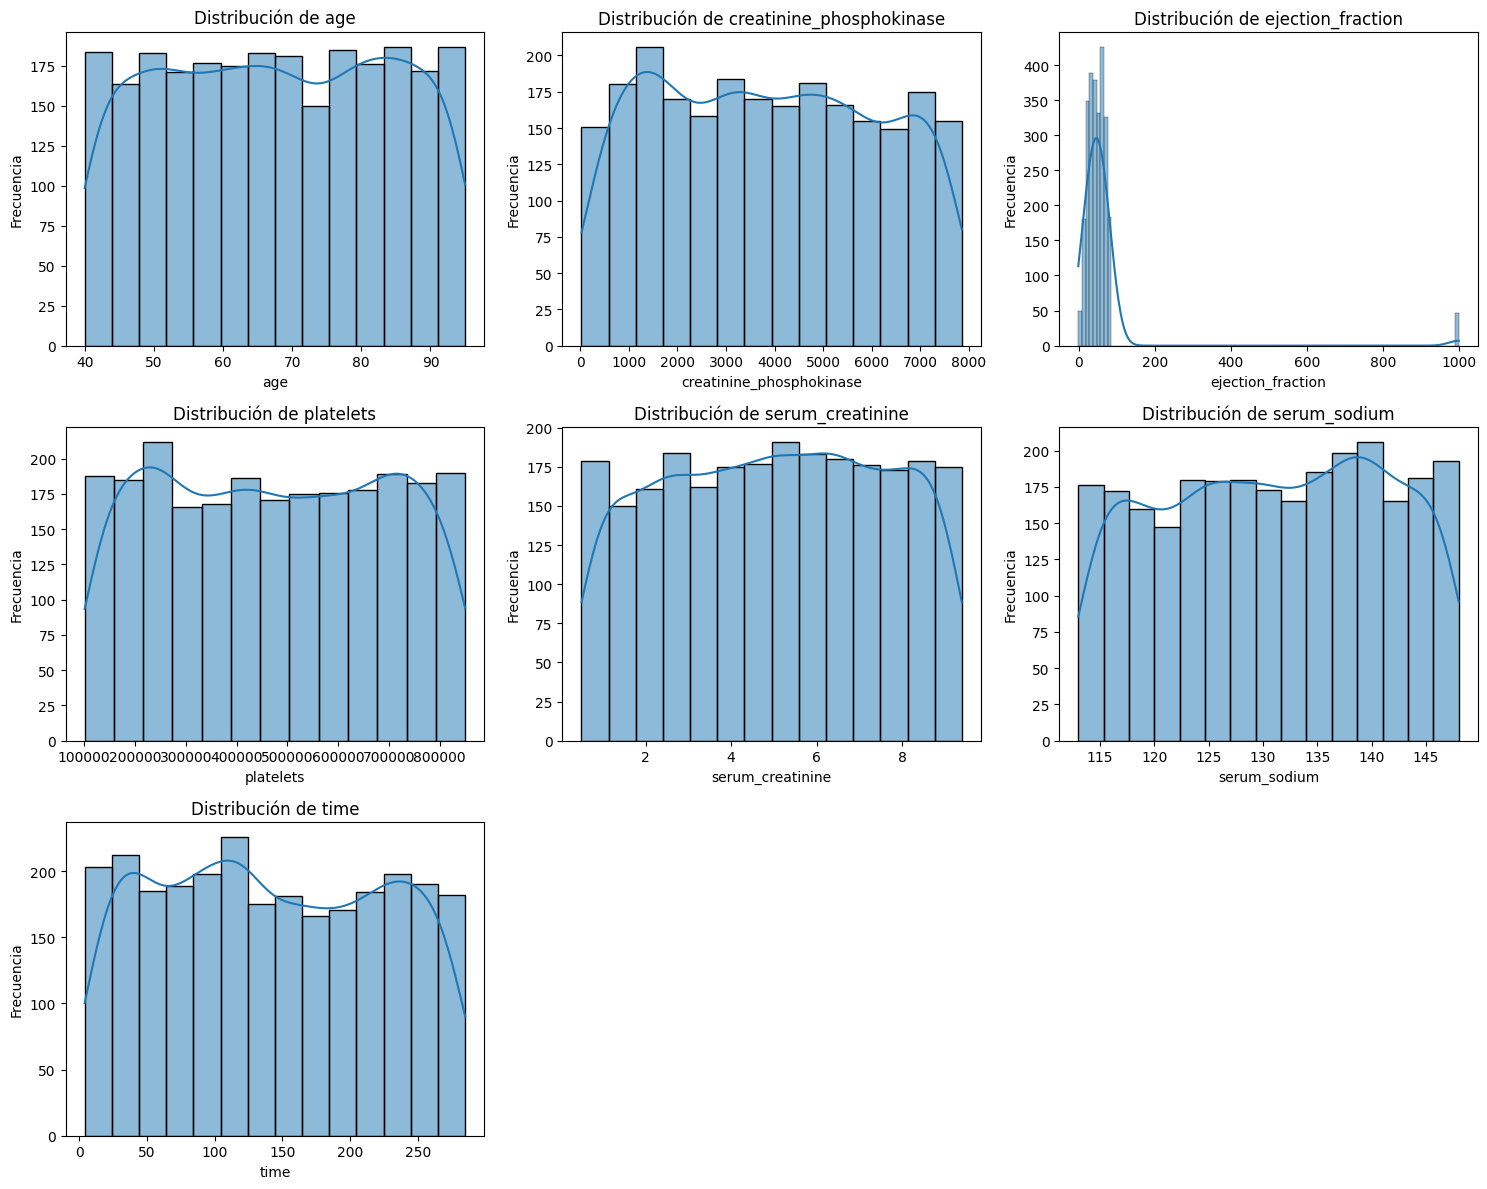

In [293]:
# Obtener columnas numéricas (excluyendo booleanas)
numeric_cols = df.select_dtypes(exclude=['boolean']).columns

# Calcular número de filas y columnas para el subplot
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Crear figura
plt.figure(figsize=(15, 4*n_rows))

# Crear subplots para cada variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### Se observan datos atipicos en ejection fraction 

In [294]:
# Se elimina los valores atípicos en ejection_fraction
df['ejection_fraction'] = df['ejection_fraction'].apply(lambda x: np.nan if x < 0 or x > 200 else x)

In [295]:
bins = [39, 45, 50, 55, 60, 65, 70, 75, 80, 95]
labels = ["40-45", "46-50", "51-55", "56-60", "61-65", "66-70", "71-75", "76-80", "81-95"]

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

df[['age', 'age_group']].head()

,age,age_group
0,78,76-80
1,91,81-95
2,68,66-70
3,54,51-55
4,82,81-95


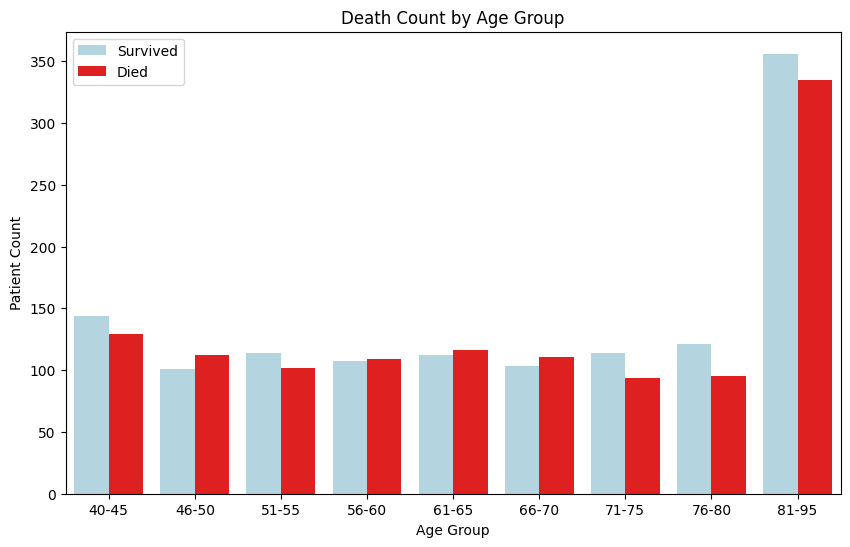

In [296]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='age_group', hue='DEATH_EVENT', palette=["lightblue", "red"])
plt.title("Death Count by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Patient Count")
plt.legend(["Survived", "Died"])
plt.show()

La gráfica muestra que, aunque los grupos de edad intermedios (ej. 51–65) concentran el mayor número absoluto de pacientes sobrevivientes, la proporción de fallecidos aumenta claramente en los grupos de mayor edad; especialmente 71–75 y 81–95 presentan tasas de mortalidad notablemente más altas que los grupos jóvenes; esto sugiere una relación positiva entre edad y riesgo de muerte durante el seguimiento.

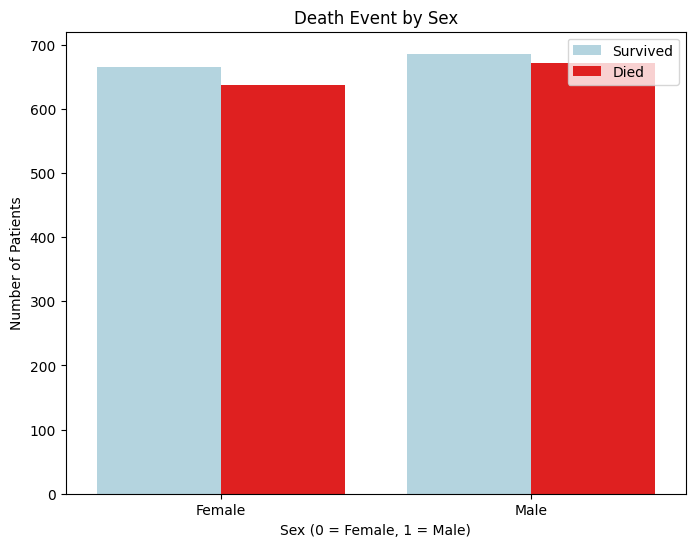

In [297]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='sex', hue='DEATH_EVENT', palette=["lightblue", "red"])

plt.title("Death Event by Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Number of Patients")
plt.legend(["Survived", "Died"])
plt.xticks([0, 1], ["Female", "Male"])
plt.show()

En la gráfica por sexo se observa que hay más pacientes hombres que mujeres y, en valores absolutos, también más muertes entre los hombres; no obstante, al mirar la proporción de fallecidos dentro de cada grupo la diferencia parece menos contundente y podría ser pequeña o nula —es decir, el mayor número de muertes en hombres puede deberse en parte al mayor tamaño de esa submuestra. 

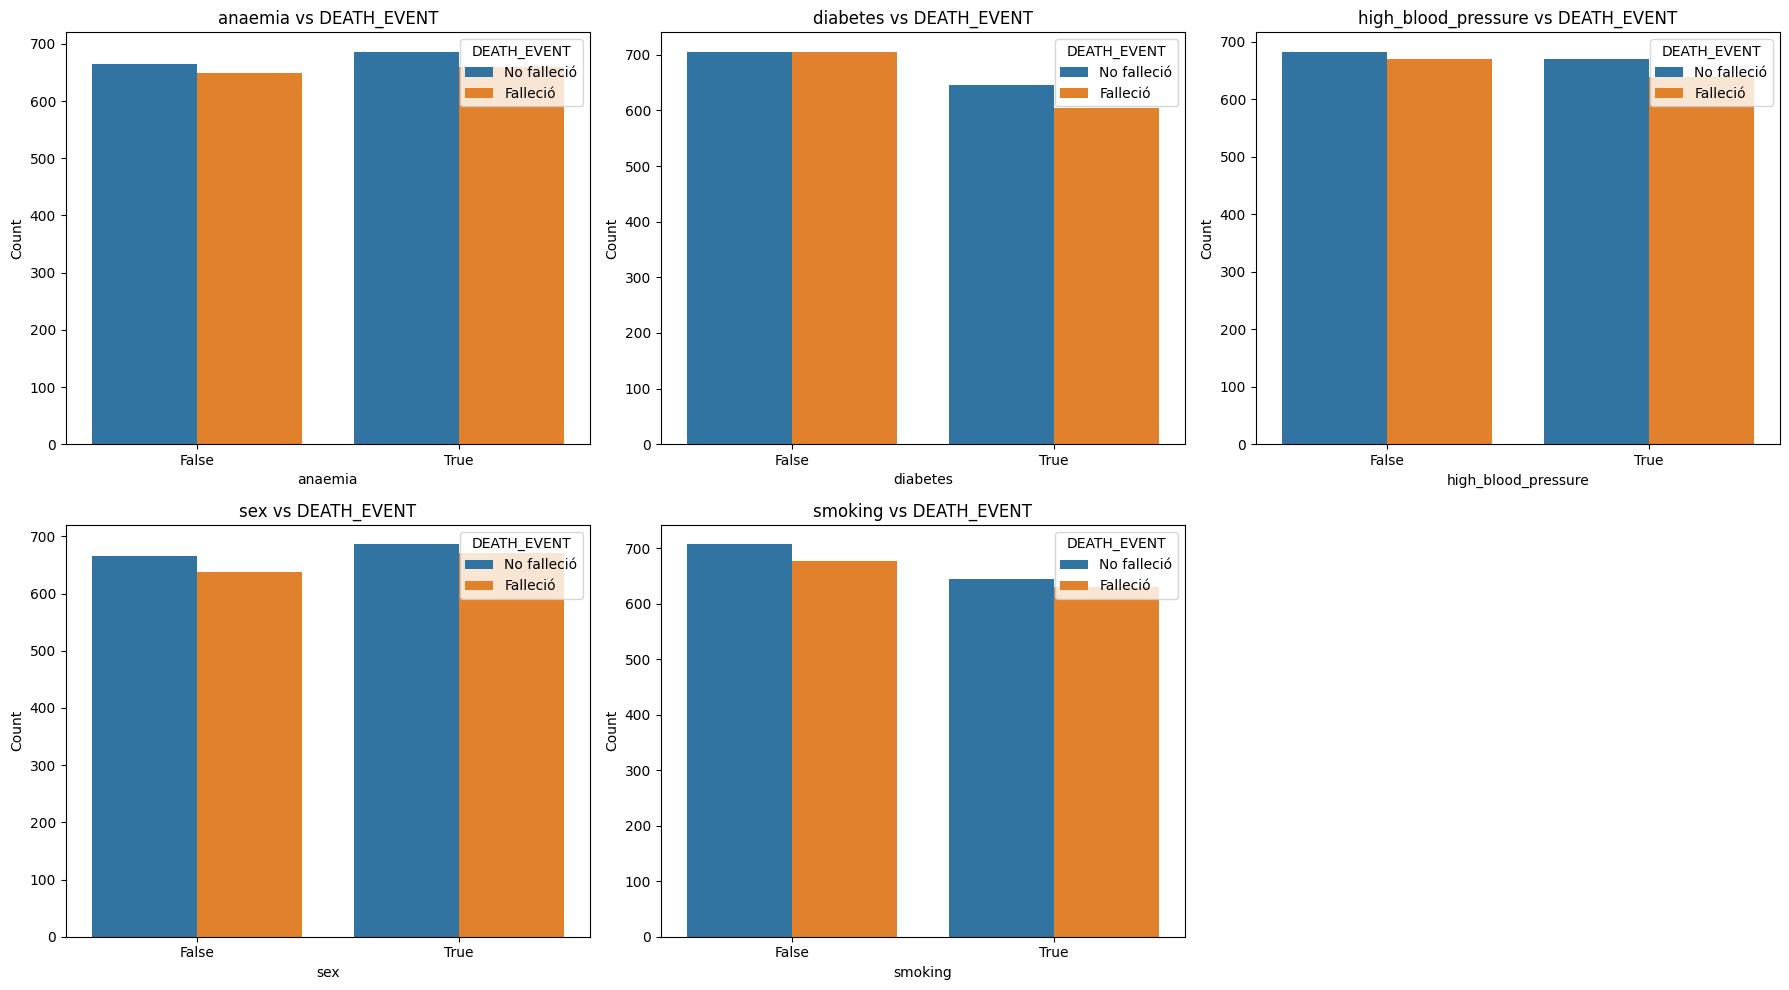

In [298]:
# Variables binarias que quieres comparar
binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

# Crear subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Graficar cada variable
for i, var in enumerate(binary_vars):
    sns.countplot(data=df, x=var, hue='DEATH_EVENT', ax=axes[i])
    axes[i].set_title(f'{var} vs DEATH_EVENT')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='DEATH_EVENT', labels=['No falleció', 'Falleció'])

# Eliminar subplot vacío si hay uno
if len(binary_vars) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Anaemia
Observación visual: la barra roja (fallecidos) relativa al total del grupo parece más alta en pacientes con anaemia (True) que en los que no tienen anaemia (False).
Interpretación: sugiere que la presencia de anemia está asociada a una mayor proporción de fallecimientos en el seguimiento. Clínicamente plausible: la anemia puede reflejar peor estado general o comorbilidades.
Señal: moderada-fuerte visualmente (la diferencia de proporción es notable).

Diabetes
Observación visual: también aquí la proporción de muertes parece mayor entre los diabéticos (True) que entre los no diabéticos.
Interpretación: indica una asociación positiva entre diabetes y mortalidad. Podría reflejar mayor carga de comorbilidad o peor pronóstico.
Señal: moderada; la diferencia es apreciable pero no tan grande como en algunos otros factores (según la gráfica).

High_blood_pressure (hipertensión)
Observación visual: se ve un mayor número absoluto de muertes en quienes tienen hipertensión (True) comparado con No, y la proporción de muertes dentro de «True» parece superior.
Interpretación: hipertensión podría asociarse a mayor riesgo, aunque en muchos estudios su efecto depende de control, edad y otros factores cardiovasculares.
Señal: moderada; comparable a diabetes/anaemia.

Sex (sexo)
Observación visual: hay muchos más hombres que mujeres en la muestra; en valores absolutos hay más muertes entre hombres (barra roja masculina mayor).
Interpretación: el mayor número de muertes en hombres podría deberse a (a) mayor tamaño de la submuestra masculina o (b) un riesgo real mayor en hombres. Visualmente, la proporción no parece tan distinta como los conteos absolutos; por tanto la diferencia puede ser en gran parte por el mayor número de hombres.
Señal: débil-moderada; necesita comparar proporciones (tasa de muerte por sexo) antes de concluir un efecto fuerte.

Smoking (tabaquismo)
Observación visual: los fumadores (True) muestran una proporción de fallecidos claramente mayor que los no fumadores.
Interpretación: tabaquismo asociado a mayor mortalidad, coherente con efectos sobre enfermedad cardiovascular y comorbilidades.
Señal: moderada-fuerte.

<Axes: >

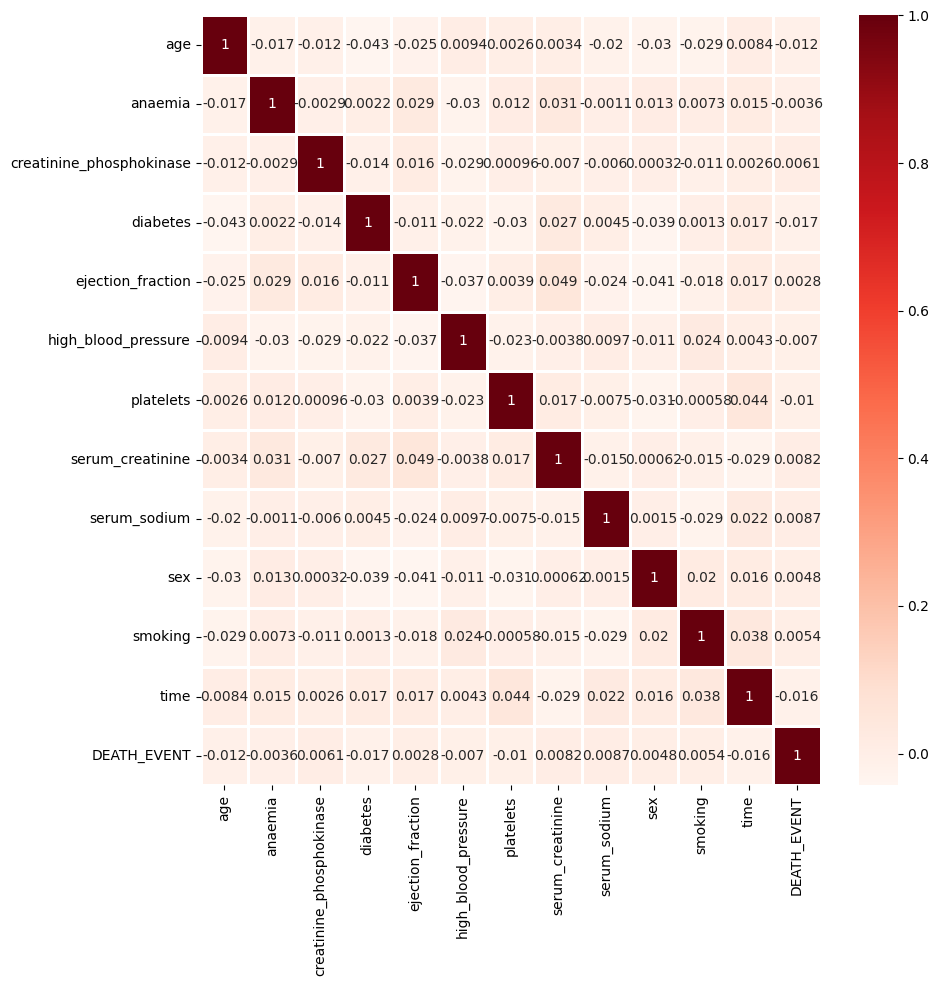

In [299]:
df.drop(columns=['age_group'], inplace=True)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap="Reds",annot=True,linewidth=1)

La matriz muestra que las variables más asociadas con la muerte son serum_creatinine (r ≈ +0.29) y age (r ≈ +0.25), mientras que ejection_fraction presenta una correlación negativa relevante (r ≈ −0.27): es decir, mayor creatinina y edad y menor fracción de eyección se asocian con mayor probabilidad de DEATH_EVENT. También destaca serum_sodium con correlación negativa moderada (≈ −0.20). Muchas de las variables binarias (anaemia, diabetes, hipertensión, smoking, sex) tienen correlaciones pequeñas con DEATH_EVENT en términos de Pearson, aunque visualmente algunas muestran señales; además sex y smoking están moderadamente correlacionadas entre sí (≈ +0.45).

### Preprocesamiento y modelado

In [300]:
# 1. Primero veamos los nulos antes de la transformación
print("Nulos antes de la transformación:")
display(df.isnull().sum())

# 2. Definir los features y transformadores
numeric_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                   'platelets', 'serum_creatinine', 'serum_sodium', 'time']
boolean_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

# Pipeline para features numéricas con verificación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Añadimos verbose=True
    ('scaler', StandardScaler())
])

# Pipeline para features booleanas con verificación
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Añadimos verbose=True
    ('encoder', OneHotEncoder(drop='if_binary'))  # Cambiamos a sparse=False
])

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bool', boolean_transformer, boolean_features)
    ],
    verbose=True  # Añadimos verbose=True
)

# Pipeline completo
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
], verbose=True)  # Añadimos verbose=True

# Preparar datos
X = df[[col for col in df.columns if col != 'DEATH_EVENT']]
y = df['DEATH_EVENT']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar shapes antes del entrenamiento
print("\nFormas de los conjuntos de datos:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Entrenar con try-except para capturar errores
try:
    clf.fit(X_train, y_train)
    
    # Verificar si hay nulos después de la transformación
    X_train_transformed = preprocessor.transform(X_train)
    print("\nShape después de la transformación:", X_train_transformed.shape)
    print("Hay nulos en X_train_transformed:", np.isnan(X_train_transformed).any())
    
    # Predicciones
    predictions = clf.predict(X_test)
    
except Exception as e:
    print("\nError durante el entrenamiento:")
    print(e)
    print("\nTipos de datos en X_train:")
    print(X_train.dtypes)

# Mostrar las primeras predicciones vs valores reales
print("\nPrimeras 10 predicciones vs valores reales:")
comparison_df = pd.DataFrame({
    'Predicción': predictions[:10],
    'Valor Real': y_test.iloc[:10]
})
display(comparison_df)

# Calcular y mostrar accuracy
accuracy = (predictions == y_test).mean()
print(f"\nExactitud del modelo: {accuracy:.2%}")

# También podemos mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report
print("\nMatriz de confusión:")
display(pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=['Pred Negativo', 'Pred Positivo'],
    index=['Real Negativo', 'Real Positivo']
))

print("\nReporte de clasificación:")
print(classification_report(y_test, predictions))

Nulos antes de la transformación:


age                         185
anaemia                       0
creatinine_phosphokinase    295
diabetes                      0
ejection_fraction            96
high_blood_pressure           0
platelets                   293
serum_creatinine            215
serum_sodium                  0
sex                           0
smoking                       0
time                          0
DEATH_EVENT                   0
dtype: int64


Formas de los conjuntos de datos:
X_train shape: (2128, 12)
X_test shape: (532, 12)
y_train shape: (2128,)
y_test shape: (532,)
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] .......... (2 of 2) Processing bool, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.6s

Shape después de la transformación: (2128, 12)
Hay nulos en X_train_transformed: False

Primeras 10 predicciones vs valores reales:


,Predicción,Valor Real
2196,1.0,True
124,0.0,True
1239,1.0,False
1791,0.0,False
1499,0.0,True
704,1.0,False
1889,1.0,False
2251,1.0,True
173,0.0,True
484,0.0,False



Exactitud del modelo: 46.62%

Matriz de confusión:


,Pred Negativo,Pred Positivo
Real Negativo,131,129
Real Positivo,155,117



Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.46      0.50      0.48       260
         1.0       0.48      0.43      0.45       272

    accuracy                           0.47       532
   macro avg       0.47      0.47      0.47       532
weighted avg       0.47      0.47      0.47       532



📊 Resultados - Regresión Logística
Accuracy: 0.4835
              precision    recall  f1-score   support

         0.0       0.50      0.64      0.56       201
         1.0       0.46      0.32      0.38       192

    accuracy                           0.48       393
   macro avg       0.48      0.48      0.47       393
weighted avg       0.48      0.48      0.47       393



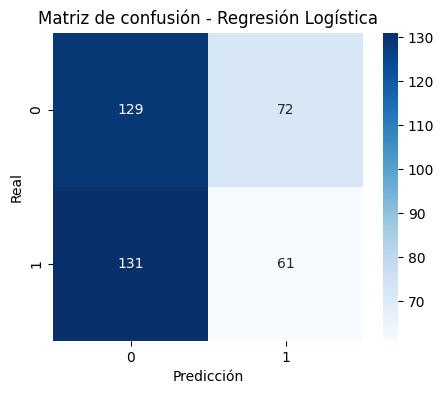


🌲 Resultados - Random Forest
Accuracy: 0.4809
              precision    recall  f1-score   support

         0.0       0.49      0.52      0.51       201
         1.0       0.47      0.44      0.45       192

    accuracy                           0.48       393
   macro avg       0.48      0.48      0.48       393
weighted avg       0.48      0.48      0.48       393



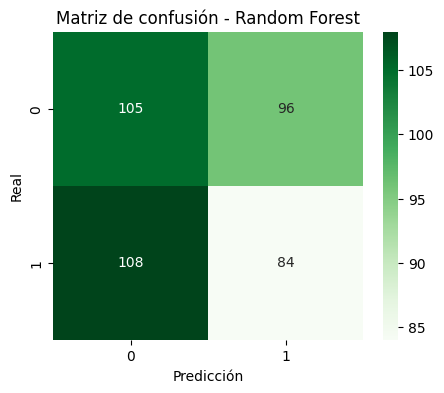

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Se crea una copia del df pero sin valores nulos
df_without_nulls = df.dropna()

# Se separa la variable objetivo
X = df_without_nulls.drop('DEATH_EVENT', axis=1)
y = df_without_nulls['DEATH_EVENT']

# Se divide las variables de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Se escalan las variables (Solo para regresion logistica)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 🔹 REGRESIÓN LOGÍSTICA
# ==========================
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("📊 Resultados - Regresión Logística")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 4))
print(classification_report(y_test, y_pred_log))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ==========================
# 🌲 RANDOM FOREST
# ==========================
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🌲 Resultados - Random Forest")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()